# Natural Language Processing

> Penggunaan NLP pada case kali ini adalah untuk mendapatkan insight terkait hal apa saja yang membuat customer senang, kecewa, ataupun netral. Penggunaan NLP kali ini bertujuan untuk mendapatkan top words dari keseluruhan review customer berdasarkan tiap-tiap ratingnya.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import string
import itertools
from nltk.stem import RSLPStemmer
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_cust = pd.read_csv('olist_customers_dataset.csv')
df_geo = pd.read_csv('olist_geolocation_dataset.csv')
df_order = pd.read_csv('olist_order_items_dataset.csv')
df_payment = pd.read_csv('olist_order_payments_dataset.csv')
df_review = pd.read_csv('olist_order_reviews_dataset.csv') #belum clean
df_delivery = pd.read_csv('olist_orders_dataset.csv')
df_product = pd.read_csv('olist_products_dataset.csv') #belum clean
df_seller = pd.read_csv('olist_sellers_dataset.csv')
df_catprod = pd.read_csv('product_category_name_translation.csv')

In [3]:
all_table = [df_cust, df_geo, df_order, df_payment, df_review, df_delivery, df_product, df_seller, df_catprod]
name_table = ['Data Customer', 'Data Geografis', 'Data Order', 'Data Payment', 'Data Review', 'Data Delivery', 'Data Produk', 'Data Seller','Data Kategori Produk']

# Pre Processing Data

> Pre Processing data kali ini dilakukan untuk mendapatkan data yang akan kita gunakan saja, adapun data yang akan digunaka pada case ini adalah data **review comment** dan juga **review score**.

In [4]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
review_id                  100000 non-null object
order_id                   100000 non-null object
review_score               100000 non-null int64
review_comment_title       11715 non-null object
review_comment_message     41753 non-null object
review_creation_date       100000 non-null object
review_answer_timestamp    100000 non-null object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [5]:
df_review.dropna(subset=['review_comment_message'],inplace=True)
df_review.drop(columns=['review_comment_title','review_creation_date','review_answer_timestamp'], inplace=True)
df_review.head()

,review_id,order_id,review_score,review_comment_message
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,Recebi bem antes do prazo estipulado.
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,Parabéns lojas lannister adorei comprar pela I...
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,aparelho eficiente. no site a marca do aparelh...
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,5,"Vendedor confiável, produto ok e entrega antes..."


### Remove non-desired elements at the comments

In [6]:
#remove \r from reviews
def clean_text(x):
    remove_r = re.sub("\r"," ", x)
    return ' '.join(remove_r.split()).lower()

#remove number from reviews
def clean_number(x):
    remove_number = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'numero', x)
    return ' '.join(remove_number.split()).lower()

#remove currency
def clean_curr(x):
    remove_curr = re.sub(r'r\$', ' ',x)
    return ' '.join(remove_curr.split()).lower()

#remove character
def clean_char(x):
    remove_char = re.sub(r'\W', ' ', x)
    return ' '.join(remove_char.split()).lower()
df_review['review_comment_message_clean'] = df_review['review_comment_message'].apply(clean_text)
df_review['review_comment_message_clean'] = df_review['review_comment_message_clean'].apply(clean_number)
df_review['review_comment_message_clean'] = df_review['review_comment_message_clean'].apply(clean_curr)
df_review['review_comment_message_clean'] = df_review['review_comment_message_clean'].apply(clean_char)
df_review = df_review.drop(columns=['review_id','order_id'])
df_review.head()

,review_score,review_comment_message,review_comment_message_clean
3,5,Recebi bem antes do prazo estipulado.,recebi bem antes do prazo estipulado
4,5,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar pela i...
9,4,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente no site a marca do aparelho...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",mas um pouco travando pelo valor ta boa
15,5,"Vendedor confiável, produto ok e entrega antes...",vendedor confiável produto ok e entrega antes ...


### Stopword and Stemming

In [7]:
def text_process(c):
    nopunc = [char for char in c if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('portuguese')]

In [8]:
df_review['review_comment_message_clean'] = df_review['review_comment_message_clean'].apply(text_process)
df_review['review_comment_message_clean'] = df_review['review_comment_message_clean'].apply(lambda x: ' '.join(x))
df_review['review_comment_message_clean'].head()

3                     recebi bem antes prazo estipulado
4     parabéns lojas lannister adorei comprar intern...
9     aparelho eficiente site marca aparelho impress...
12                          pouco travando valor ta boa
15    vendedor confiável produto ok entrega antes prazo
Name: review_comment_message_clean, dtype: object

In [9]:
import nltk
nltk.download('rslp')

[nltk_data] Downloading package rslp to
[nltk_data]     /Users/cahyawahyuni/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [10]:
def stem_processing(c):
    stemmer = RSLPStemmer()
    return list(map(lambda x: stemmer.stem(x), [word for word in c.split()]))
df_review['review_comment_message_steam'] = df_review['review_comment_message_clean'].apply(stem_processing)
df_review['review_comment_message_steam'] = df_review['review_comment_message_steam'].apply(lambda x: ' '.join(x))
df_review.head()

,review_score,review_comment_message,review_comment_message_clean,review_comment_message_steam
3,5,Recebi bem antes do prazo estipulado.,recebi bem antes prazo estipulado,receb bem ant praz estipul
4,5,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar intern...,parabém loj lannist ador compr internet segur ...
9,4,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente site marca aparelho impress...,aparelh efici sit marc aparelh impress numerod...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travando valor ta boa,pouc trav val ta boa
15,5,"Vendedor confiável, produto ok e entrega antes...",vendedor confiável produto ok entrega antes prazo,vend confi produt ok entreg ant praz


# TF/IDF

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [12]:
count_vectorizer_transformer = CountVectorizer().fit(df_review['review_comment_message_steam'])
count_vectorizer_res = count_vectorizer_transformer.transform(df_review['review_comment_message_steam'])
pd.DataFrame(count_vectorizer_res.todense(), columns=count_vectorizer_transformer.get_feature_names()).head()

,aa,aaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaguard,aaind,aanch,aaprelh,ab,aba,abaf,...,ônibu,ônu,ötim,últ,úmid,únic,úte,útel,útil,ünic
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
tf_idf_transformer = TfidfTransformer().fit(count_vectorizer_res)
tf_idf_res = tf_idf_transformer.transform(count_vectorizer_res)

In [14]:
df_tf_idf = pd.DataFrame(tf_idf_res.todense(), columns=count_vectorizer_transformer.get_feature_names())

In [15]:
meaningfull_words = []
for item in range(len(df_tf_idf)):
    words = list(df_tf_idf.iloc[item].sort_values(ascending=False).head(3).index)
    meaningfull_words.append(words)
    
df_review['meaningfull_words'] = meaningfull_words
df_review.head()

,review_score,review_comment_message,review_comment_message_clean,review_comment_message_steam,meaningfull_words
3,5,Recebi bem antes do prazo estipulado.,recebi bem antes prazo estipulado,receb bem ant praz estipul,"[estipul, bem, ant]"
4,5,Parabéns lojas lannister adorei comprar pela I...,parabéns lojas lannister adorei comprar intern...,parabém loj lannist ador compr internet segur ...,"[pásco, parabém, prát]"
9,4,aparelho eficiente. no site a marca do aparelh...,aparelho eficiente site marca aparelho impress...,aparelh efici sit marc aparelh impress numerod...,"[aparelh, marc, numerodesinfec]"
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",pouco travando valor ta boa,pouc trav val ta boa,"[trav, ta, pouc]"
15,5,"Vendedor confiável, produto ok e entrega antes...",vendedor confiável produto ok entrega antes prazo,vend confi produt ok entreg ant praz,"[confi, ok, vend]"


## EDA

In [16]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/cahyawahyuni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
from googletrans import Translator
translator = Translator()

In [37]:
def graph_most_words_appear(data):
    all_words = ' '.join(list(data))
    list_all_words = all_words.split()
    word_count = Counter(list_all_words)
    word_count_series = pd.Series(word_count)
    word_wo_stopwords = []
    for item in word_count_series.index:
        if (item not in stopwords.words('portuguese')):
            word_wo_stopwords.append(item)
    word_count_series = word_count_series.loc[word_wo_stopwords]
    most_words_appear = word_count_series.sort_values(ascending=False).head(20)
    sns.set_style('whitegrid')
    plt.figure(figsize=(15,5))
    sns.barplot(most_words_appear.index,most_words_appear.values)
    eng_word = []
    for item in list(most_words_appear.index):
        word = translator.translate(item, dest='English').text
        eng_word.append(word)
    plt.show()
    print(eng_word)

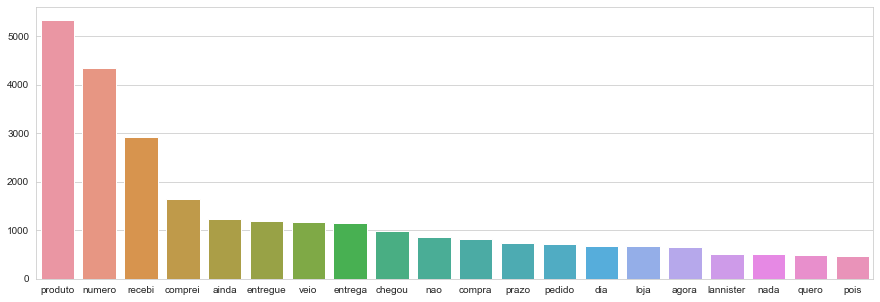

['product', 'number', 'I received', 'I bought', 'still', 'delivered', 'came', 'delivery', 'has arrived', 'not', 'purchase', 'term', 'order', 'day', 'store', 'now', 'lannister', 'nothing', 'I want', 'because']


In [39]:
graph_most_words_appear(df_review[df_review['review_score'] == 1]['review_comment_message_clean'])

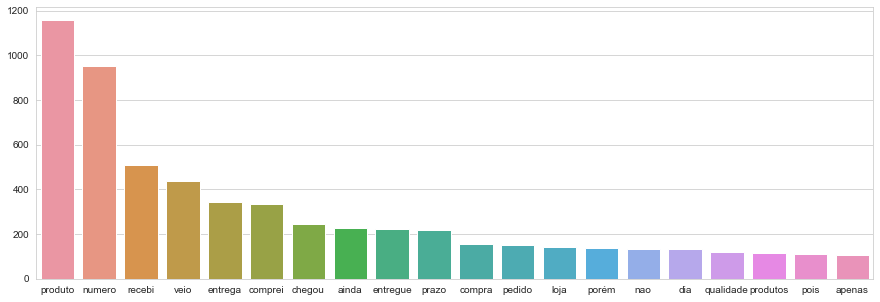

['product', 'number', 'I received', 'came', 'delivery', 'I bought', 'has arrived', 'still', 'delivered', 'term', 'purchase', 'order', 'store', 'however', 'not', 'day', 'quality', 'products', 'because', 'only']


In [40]:
graph_most_words_appear(df_review[df_review['review_score'] == 2]['review_comment_message_clean'])

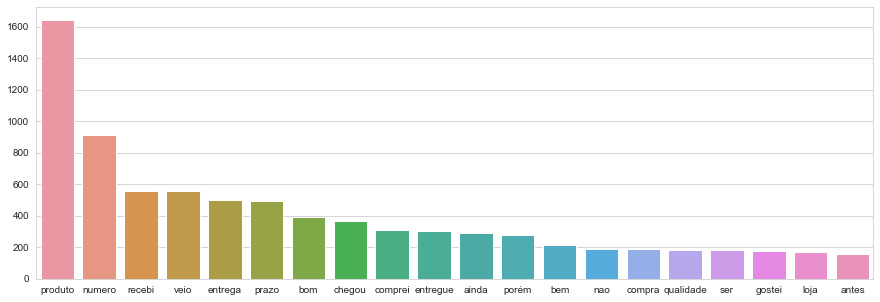

['product', 'number', 'I received', 'came', 'delivery', 'term', 'good', 'has arrived', 'I bought', 'delivered', 'still', 'however', 'good', 'not', 'purchase', 'quality', 'to be', 'liked it', 'store', 'before']


In [41]:
graph_most_words_appear(df_review[df_review['review_score'] == 3]['review_comment_message_clean'])

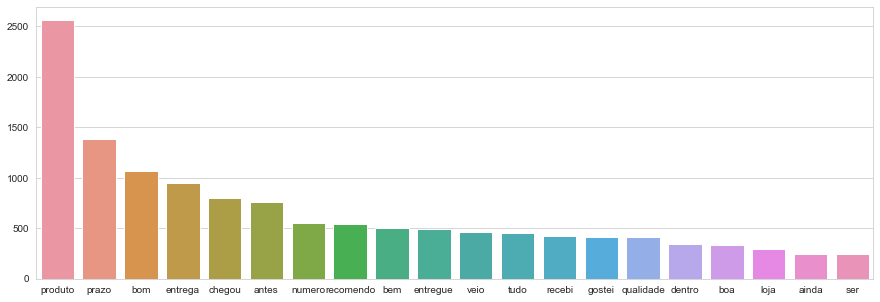

['product', 'term', 'good', 'delivery', 'has arrived', 'before', 'number', 'I recommend', 'good', 'delivered', 'came', 'all', 'I received', 'liked it', 'quality', 'inside', 'good', 'store', 'still', 'to be']


In [42]:
graph_most_words_appear(df_review[df_review['review_score'] == 4]['review_comment_message_clean'])

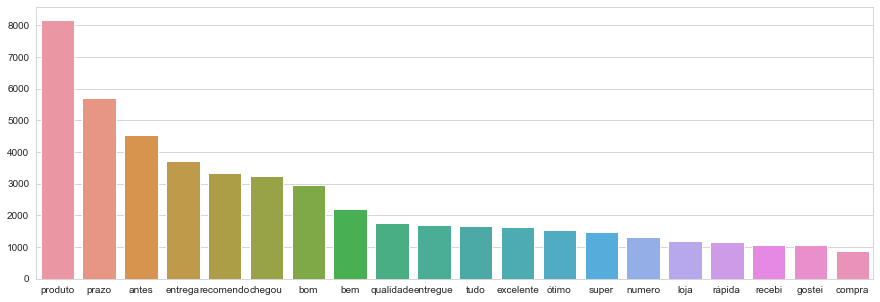

['product', 'term', 'before', 'delivery', 'I recommend', 'has arrived', 'good', 'good', 'quality', 'delivered', 'all', 'Excellent', 'great', 'super', 'number', 'store', 'fast', 'I received', 'liked it', 'purchase']


In [43]:
graph_most_words_appear(df_review[df_review['review_score'] == 5]['review_comment_message_clean'])

In [19]:
def show_most_words_appear(data):
    all_words = ' '.join(list(data))
    list_all_words = all_words.split()
    word_count = Counter(list_all_words)
    word_count_series = pd.Series(word_count)
    word_wo_stopwords = []
    for item in word_count_series.index:
        if (item not in stopwords.words('portuguese')):
            word_wo_stopwords.append(item)
    word_count_series = word_count_series.loc[word_wo_stopwords]
    most_words_appear = word_count_series.sort_values(ascending=False).head(20)
    return most_words_appear

In [33]:
data_satu = pd.DataFrame(show_most_words_appear(df_review[df_review['review_score'] == 1]['review_comment_message_clean'])).reset_index().rename(columns={'index':'word',0:'appear'})
eng_word_satu = []
for item in list(data_satu['word']):
    word = translator.translate(item, dest='English').text
    eng_word_satu.append(word)
    
data_dua = pd.DataFrame(show_most_words_appear(df_review[df_review['review_score'] == 2]['review_comment_message_clean'])).reset_index().rename(columns={'index':'word',0:'appear'})
eng_word_dua = []
for item in list(data_dua['word']):
    word = translator.translate(item, dest='English').text
    eng_word_dua.append(word)
    
data_tiga = pd.DataFrame(show_most_words_appear(df_review[df_review['review_score'] == 3]['review_comment_message_clean'])).reset_index().rename(columns={'index':'word',0:'appear'})
eng_word_tiga = []
for item in list(data_tiga['word']):
    word = translator.translate(item, dest='English').text
    eng_word_tiga.append(word)
    
data_empat = pd.DataFrame(show_most_words_appear(df_review[df_review['review_score'] == 4]['review_comment_message_clean'])).reset_index().rename(columns={'index':'word',0:'appear'})
eng_word_empat = []
for item in list(data_empat['word']):
    word = translator.translate(item, dest='English').text
    eng_word_empat.append(word)
    
data_lima = pd.DataFrame(show_most_words_appear(df_review[df_review['review_score'] == 5]['review_comment_message_clean'])).reset_index().rename(columns={'index':'word',0:'appear'})
eng_word_lima = []
for item in list(data_lima['word']):
    word = translator.translate(item, dest='English').text
    eng_word_lima.append(word)

In [36]:
import pickle
filename = 'data_satu.sav'
pickle.dump(data_satu, open(filename , 'wb'))

filename = 'data_dua.sav'
pickle.dump(data_dua, open(filename , 'wb'))

filename = 'data_tiga.sav'
pickle.dump(data_tiga, open(filename , 'wb'))

filename = 'data_empat.sav'
pickle.dump(data_empat, open(filename , 'wb'))

filename = 'data_lima.sav'
pickle.dump(data_lima, open(filename , 'wb'))

filename = 'eng_word_satu.sav'
pickle.dump(eng_word_satu, open(filename , 'wb'))

filename = 'eng_word_dua.sav'
pickle.dump(eng_word_dua, open(filename , 'wb'))

filename = 'eng_word_tiga.sav'
pickle.dump(eng_word_tiga, open(filename , 'wb'))

filename = 'eng_word_empat.sav'
pickle.dump(eng_word_empat, open(filename , 'wb'))

filename = 'eng_word_lima.sav'
pickle.dump(eng_word_lima, open(filename , 'wb'))

# Conclusion

Setelah melakukan pre processing dan processing data review comment serta review score, terdapat 3 kata utama yang selalu muncul di tiap rating:

- product
- delivery
- quality

Hal ini berarti bahwa 'produk, pengiriman, dan kualitas' merupakan hal yang sangat sensitif terhadap keputusan customer dalam memberikan rating.